In [3]:
import sys
sys.path.append('/home/s/seanmacb/Camera/pkgs')
import run_six_utils as rsu
import lsst.afw.display as afwDisplay
import lsst.daf.butler as daf_butler
afwDisplay.setDefaultBackend('matplotlib') 
import matplotlib.pyplot as plt
import numpy as np
import myutils_ar.myutils as myu
import eo_pipe

# Look on amp level of R12-S20 and R31-S01 for bright pixels, and R22-S01 and R13-S01 for bright columns

Run 6b: 13550

Run 6: 13401

Run 5: 13162


---
Results from compare_run tool 
- R12-S20
    - Extremely high bright pixel counts in run 6, run 5 and 6b have comparable bright pixels
- R31-S01
    - Higher bright pixel counts generally, but lowest in run 6, highest in 6b
- R22-S01
    - Not many, but very high in run 6, comparable between run 6b and 5
- R13-S01
    - High bright pixel counts generally, but higher in run 5 and 6b, lower in 6

---


### Query the eo_brightdefects to get an idea of what amp is interesting for the above runs

In [4]:
repo = '/repo/main'
operator = 'lsstccs'
acq_runs = ['13162','13401','13550']  # Run 6, run 6b.
weeklys = ['w_2023_22','w_2023_24','w_2023_41']
repo_arr = ['/repo/main','/repo/ir2','/repo/ir2']

In [5]:
butler = daf_butler.Butler(repo)
# list(butler.registry.queryCollections('*13162*'))

# list(butler.registry.queryCollections('*13162*',collectionTypes=daf_butler.CollectionType.CHAINED))

In [6]:
df_dict = {}
for acq_run,weekly,repo in zip(acq_runs,weeklys,repo_arr):
    butler = daf_butler.Butler(repo)
    collection = butler.registry.queryCollections(f"u/{operator}/eo_*_{acq_run}_{weekly}",
                                                   collectionTypes=daf_butler.CollectionType.CHAINED)
    clean_collection = []
    for item in collection: # Only selecting the defect paths
        if item.__contains__('defects'):
            clean_collection.append(item)
            
    df_dict[int(acq_run)] = myu.eopipe_DictToDfz(eo_pipe.get_amp_data(repo,clean_collection)) # For each run
# myu.compare_tworuns(df1,df2,run1,run2,minxy,maxxy,quantity='READ_NOISE',draw_line=True,legend_loc='lower right',scale='linear',save=None,fname=None) # once in each dataframe

In [10]:
# notable_detectors = ["R12_S20","R31_S01","R22_S01","R13_S01"]
defect_list = ["BRIGHT_COLUMNS" 	,"BRIGHT_PIXELS"]
notable_detectors = ["R32_S10","R23_S10","R11_S21","R13_S10"]

kwarg_dict = [{"alpha":.9,"ls":"-","marker":"+","markersize":10,"color":"red"},
              {"alpha":.9,"ls":"--","marker":"x","markersize":10,"color":"blue"},
              {"alpha":.9,"ls":"-.","marker":".","markersize":10,"color":"green"}]

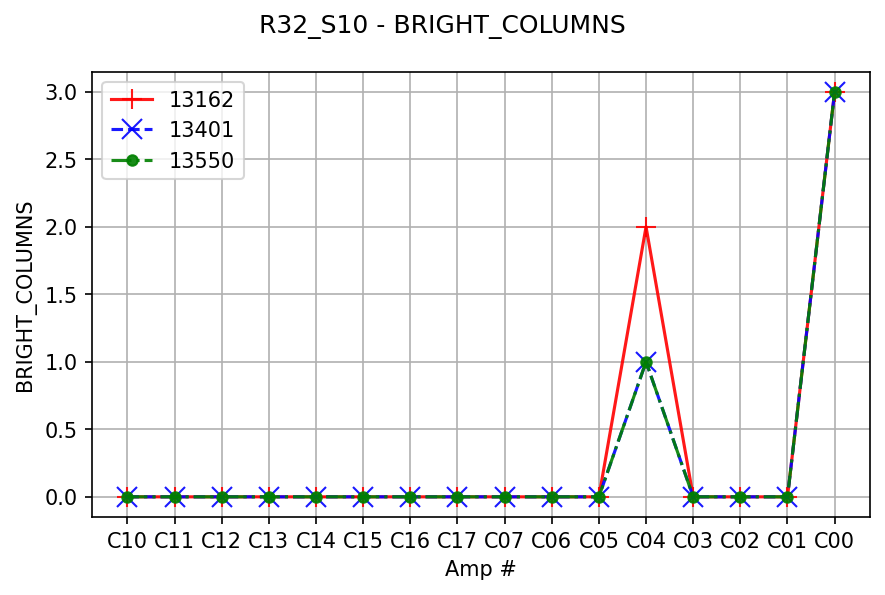

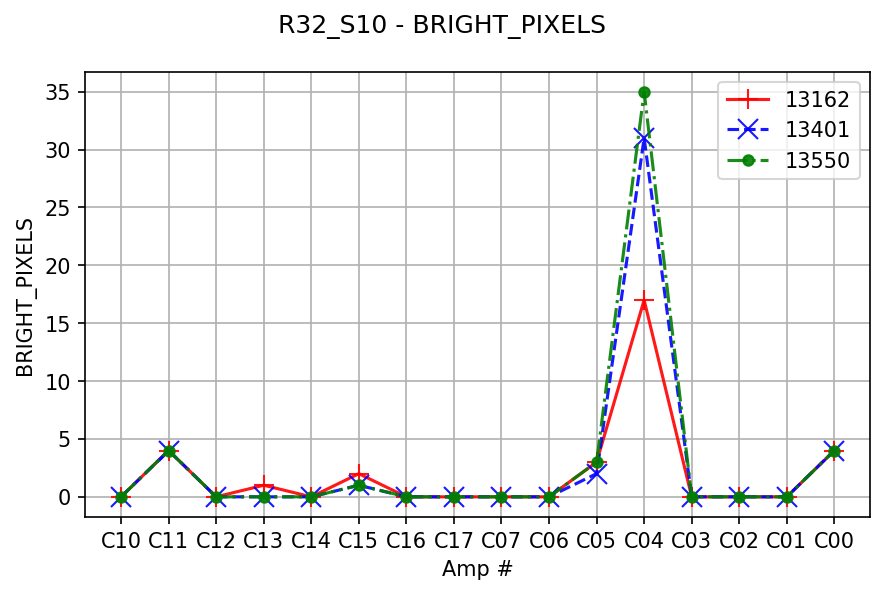

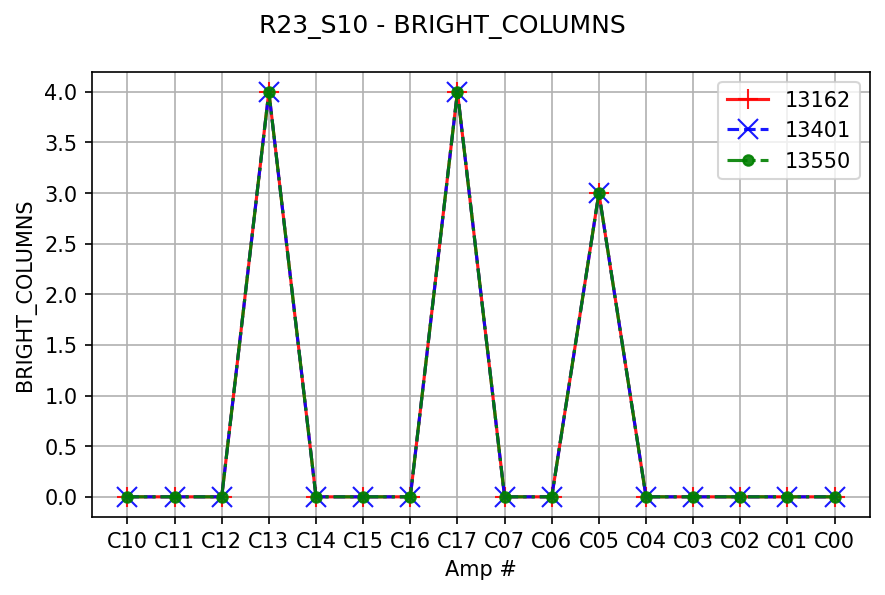

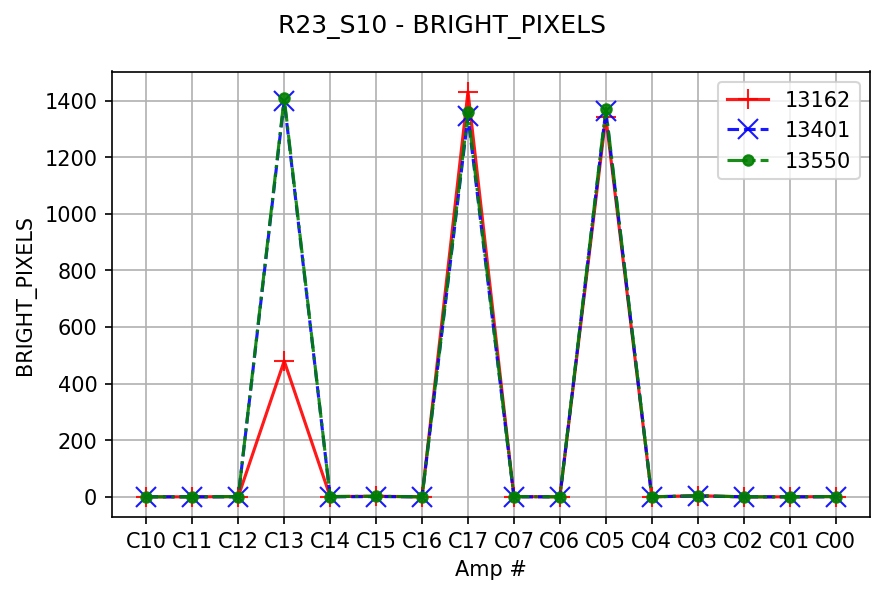

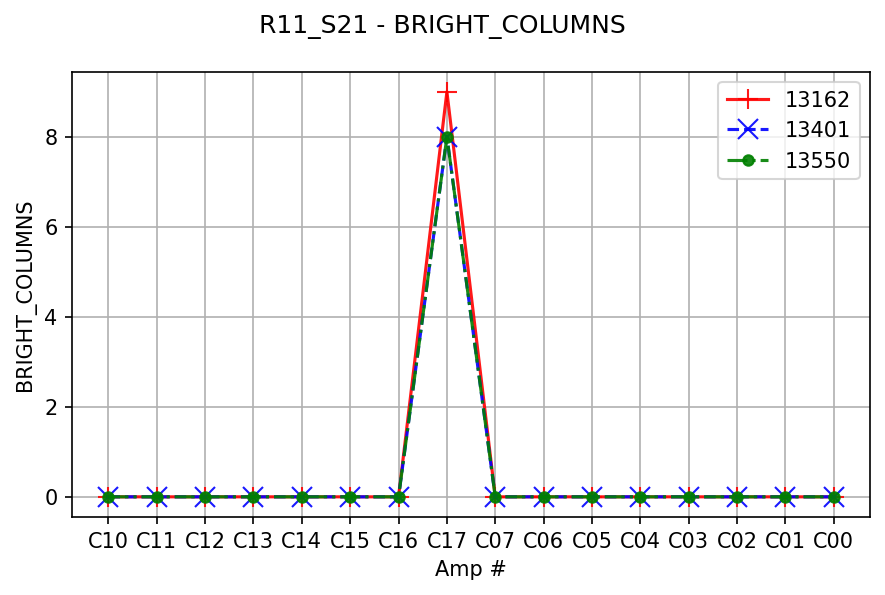

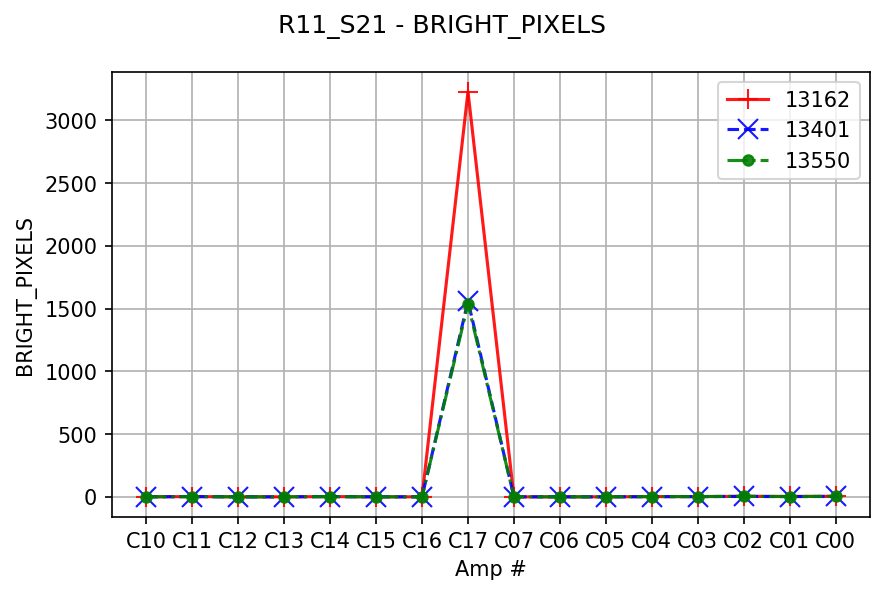

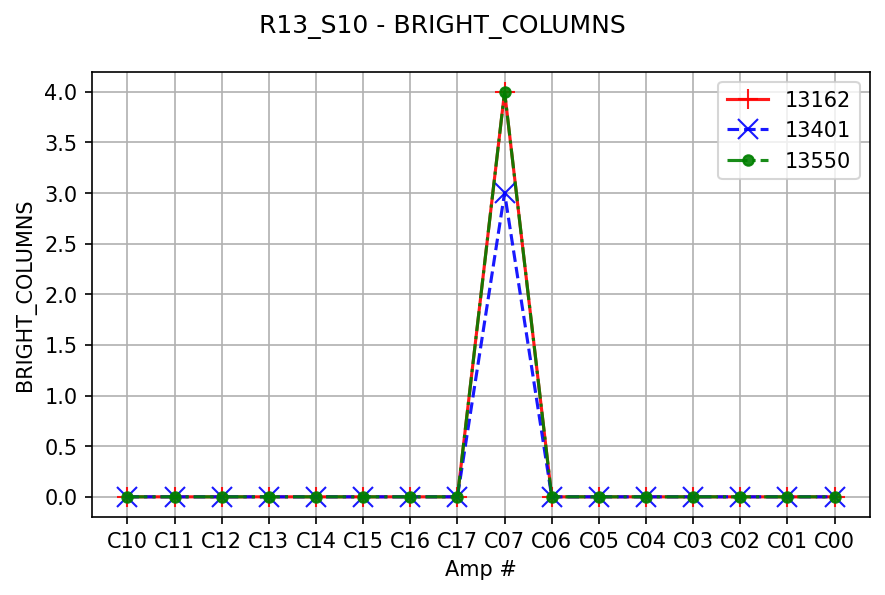

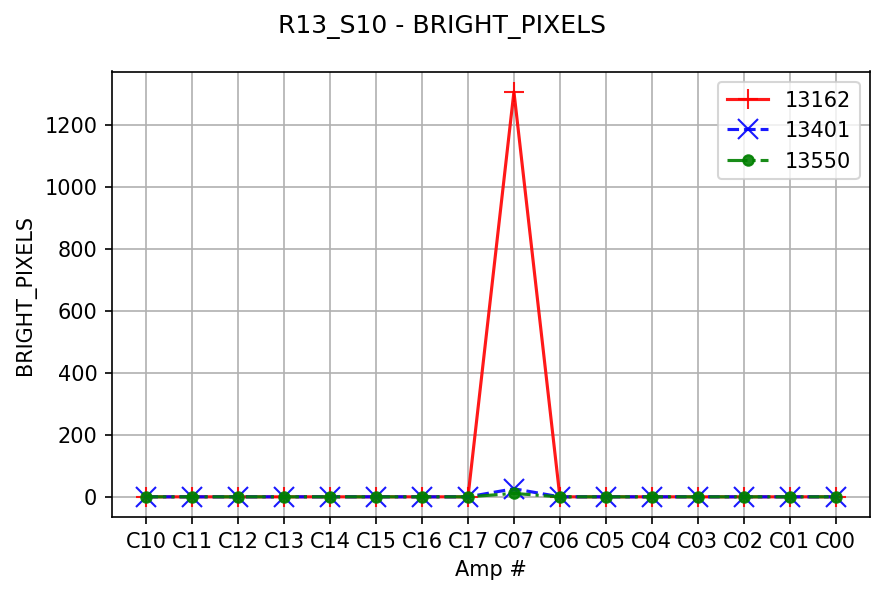

In [11]:
for detector_name in notable_detectors:
    for colName in defect_list:
        fig,ax = plt.subplots(figsize=[6,4],dpi=150)
        fig.suptitle(r"{} - {}".format(detector_name,colName))
        for k in range(len(df_dict.keys())): # querying over each run
            run_numm = list(df_dict.keys())[k]
            rundf = df_dict[run_numm][df_dict[run_numm]["BAY_SLOT"]==detector_name].sort_values("AMP")
            ax.plot(myu.bayslot_segments(detector_name),rundf[colName],label=run_numm,**kwarg_dict[k])
        # formatting figure here
        ax.grid()
        ax.set_xticks(np.arange(0,len(rundf)))
        ax.set_xlabel("Amp #")
        ax.set_ylabel(colName)
        ax.legend()
        fig.tight_layout()